# Introduction: Neural Network for learning/processing time-series/historical data

In this project, I 'll build a neural network (NN) to learn and process historical/time-series data.
The dataset, used in this project, is the bike sharing dataset.

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load, explore, and prepare the dataset

The first critical step is preparing the data correctly. 
Variables/values on different scales make it difficult for the NN to efficiently learn the correct parameters (e.g. weights and biases).

In [15]:
# To check the data in the Terminal/Konsole
% ls data/bike_data/
data_path = 'data/bike_data/hour.csv'
rides = pd.read_csv(data_path)

# # The new historical/time-seri data to visualize
# data_path_watch = 'data/watch_multisensor_data/2_Year_Data_Basis_Watch/2-year_data/Basis_Watch_Data.csv'
# watch = pd.read_csv(data_path_watch)

day.csv*  hour.csv*  Readme.txt*


### Downloading/ checking out the bike sharing dataset

Bike sharing dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. 
The number of riders is split between casual and registered, summed up in the `cnt` column. 
You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. 
NOTE: Some days don't have exactly 24 entries in the dataset, so it's not exactly 10 days.

You can see the hourly rentals here. 
This dataset is pretty complicated! 
The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week.

Looking at the dataset, we also have information about temperature, humidity, and windspeed. 
All of these factors are likely affecting the number of riders. 
You'll be trying to capture all this with your model.

In [17]:
rides.head()
rides[:10]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


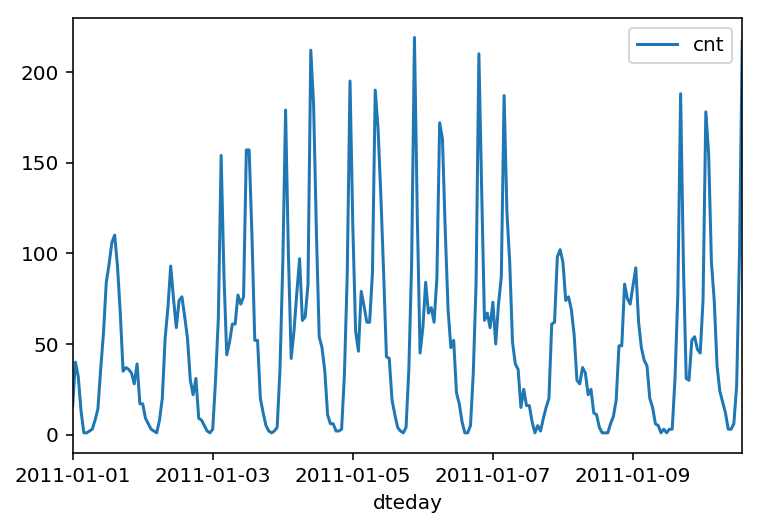

In [18]:
rides[:24*10].plot(x='dteday', y='cnt')
# watch[:1000].plot()

### Dummy variables
Here we have some categorical variables such as season, weather, and month. 
To include these in our model, we'll need to make binary dummy variables. 
This is simple to do with Pandas thanks to `get_dummies()`.

In [19]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Batch normalization for standardizing the dataset using mean and variance/ scaling the data
To training NN easier and more efficiently, we should standardize each of the continuous variables. 
we'll shift and scale the variables such that they have zero-mean and a standard deviation of 1.
These scaling factors are saved to add up to the NN predictions eventually.

In [20]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the dataset into training, validation, and testing sets

We'll save the data for the last approximately 21 days to use as test set after we've trained the network. 
We'll use this set to make predictions and compare them with the actual number of riders.

In [21]:
# Save data for approximately the last 21 days * 24 hours-per-day (24 hours/day) 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features_txn, test_targets_txm = test_data.drop(target_fields, axis=1), test_data[target_fields]
test_features_txn.shape, test_targets_txm.shape

((504, 56), (504, 3))

### Dividing the entire training data into training and validation sets to avoid overfitting and underfitting during the training

We'll split the entire training data into two sets: one for training and one for validating as NN is being trained. Since this is a time-series dataset, we'll train on historical data, then try to predict on future data (the validation set).

In [22]:
# Hold out the last 60 days for validation set
# txn: t is time/row (num of records) and n is space/col (input feature space dims)
# txm: t is time/row (num of records) and m is space/col (output feature space dims)
train_features_txn, train_targets_txm = features[:-60*24], targets[:-60*24]
valid_features_txn, valid_targets_txm = features[-60*24:], targets[-60*24:]
train_features_txn.shape, train_targets_txm.shape, valid_features_txn.shape, valid_targets_txm.shape

((15435, 56), (15435, 3), (1440, 56), (1440, 3))

## How to build the NN

Below we'll build NN architecture for learning and processing the time-series dataset. 
We've built NN architecture for the forward and the backward pass. 

we'll set the hyperparameters: the momentum, the learning rate, the number of hidden units, the number of input units, the number of output units, and the number of epochs for training passes (updating the NN parameters such as weights and biases).

The NN has three layers in general and in our case: one input layer, one/multiple hidden layer/s, and one output layer. 
The hidden layer/s uses a non-linear function for activations/probability such as the sigmoid and tanh. 
The output layer, in our case, has one node and is used for the regression, i.e. the output of the node is the same as the input of the node.
That is why the activation function is a linear unit (LU) $f(x)=x$. 

A function that takes the input signal and generates an output signal, but takes into account a threshold, is called an activation function. 
We work through each layer of our network calculating the outputs for each neuron. 
All of the outputs from one layer become inputs to the neurons on the next layer. 
This process is called *forward propagation* which happens in forward pass.

We use the NN weights to propagate signals forward (in forward pass) from the input to the output layers in NN. 
We use the weights to also propagate error backwards (in backward pass) from the output all the way back into the NN to update our weights. 
This is called *backpropagation*.

> **Hint:** We'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. 
Based on calculus, the derivative of this function is equivalent to the equation $y = x$. 
In fact, the slope of this function is the derivative of $f(x)$.

Below, we'll build the NN as follows:
1. Implement/apply an activation function such as sigmoid, tanh, or ReLU.
2. Implement the forward pass in the `train` method for forward propagation of the input data.
3. Implement the backpropagation algorithm in the `train` method in the backward pass by calculating the output error and the parameter gradients.
4. Implement the forward pass again at the end in the `run` method for the actual prediction in validation data and test data.

In [23]:
class NN(object):
    # n: num_input_units in input layer, 
    # h: num_hidden_units in the hidden layer, 
    # m: num_out_units in the output layer, and 
    # lr: learning_rate
    def __init__(self, n, h, m, lr):
        # Initialize parameters: weights and biases
        self.w_nxh = np.random.normal(loc=0.0, scale=n**(-0.5), size=(n, h))
        self.b_1xh = np.zeros(shape=(1, h))

        self.w_hxm = np.random.normal(loc=0.0, scale=h**(-0.5), size=(h, m))
        self.b_1xm = np.zeros(shape=(1, m))

        self.lr = lr
    
    # Train to update NN paramteres (w, b) in each epoch using NN hyper-parameters
    def train(self, X_txn, Y_txm):
        ''' Train the network on batch of features (X_txn) and targets (Y_txm). 
        
            Arguments
            ---------
            
            features: X_txn is a 2D array, each row is one data record (t), each column is a feature (n)
            txn: ixj, rowxcol, and hxw
            targets: Y_txm is a 2D array as well.
        
        '''
        dw_nxh = np.zeros_like(self.w_nxh)
        db_1xh = np.zeros_like(self.b_1xh)
        dw_hxm = np.zeros_like(self.w_hxm)
        db_1xm = np.zeros_like(self.b_1xm)
        
        for each_X, each_Y in zip(X_txn, Y_txm):
            #### Implement the forward pass here ####
            ### Forward pass ###
            x_1xn = np.array(each_X, ndmin=2) # [[each]]
            y_1xm = np.array(each_Y, ndmin=2) # [[each]]
            
            # TODO: Hidden layer - Replace these values with your calculations.
            h_in_1xh = (x_1xn @ self.w_nxh) + self.b_1xh # signals into hidden layer
            h_out_1xh = np.tanh(h_in_1xh)

            # TODO: Output layer - Replace these values with your calculations.
            out_logits_1xm = (h_out_1xh @ self.w_hxm) + self.b_1xm # signals into final output layer
            y_pred_1xm = np.tanh(out_logits_1xm) # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###
            dy_1xm = y_pred_1xm - y_1xm # Output layer error: difference between actual target and desired output.

            # TODO: Output error - Replace this value with your calculations.
            dout_logits_1xm = dy_1xm * (1-(np.tanh(out_logits_1xm)**2)) # dtanh= (1-(np.tanh(x))**2)
            dh_out_1xh = dout_logits_1xm @ self.w_hxm.T
            
            # TODO: Calculate the hidden layer's contribution to the error
            dh_in_1xh = dh_out_1xh * (1-(np.tanh(h_in_1xh)**2))
            dx_1xn = dh_in_1xh @ self.w_nxh.T # is dx_1xn USELESS?
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            db_1xm += dout_logits_1xm
            dw_hxm += (dout_logits_1xm.T @ h_out_1xh).T
            db_1xh += dh_in_1xh
            dw_nxh += (dh_in_1xh.T @ x_1xn).T
            
        # TODO: Update the NN parameters (w, b) in each epoch of training
        self.w_hxm -= self.lr * dw_hxm # update hidden-to-output weights with gradient descent step
        self.b_1xm -= self.lr * db_1xm # output units/neurons/cells/nodes
        self.w_nxh -= self.lr * dw_nxh # update input-to-hidden weights with gradient descent step
        self.b_1xh -= self.lr * db_1xh # hidden units/cells/neurons/nodes
 
    def run(self, X_txn):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: X_txn is a 2D array of records (t as row) and their features (n as col)
        '''
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        x_txn = X_txn

        # TODO: Hidden layer - Replace these values with your calculations.
        h_in_txh = (x_txn @ self.w_nxh) + self.b_1xh # signals into hidden layer
        h_out_txh = np.tanh(h_in_txh)

        # TODO: Output layer - Replace these values with your calculations.
        out_logits_txm = (h_out_txh @ self.w_hxm) + self.b_1xm # signals into final output layer
        y_pred_txm = np.tanh(out_logits_txm) # signals from final output layer
        
        return y_pred_txm

In [24]:
# Mean Squared-Error(MSE)
def MSE(Y_pred_1xt, Y_1xt):
    return np.mean((Y_pred_1xt-Y_1xt)**2)

## Training the NN

At first, we'll set the hyperparameters for the NN. 
The strategy here is to find hyperparameters such that the error on the training set is the low enough, but you're not underfitting or overfitting to the training set. 

If you train the NN too long or NN has too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. 
That is, the loss on the validation set will start increasing as the training set loss drops.

We'll also be using a method known as Stochastic Gradient Descent (SGD) to train the NN using Backpropagation. 
The idea is that for each training pass, you grab a either a random minibatch of the data instead of using the whole data set/full batch.

We can also use bacth gradient descent (BGD), but with SGD, each pass is much faster than BGD. 
That is why as the data size grows in number of samples, BGD is not feasible for training the NN and we have to use SGD instead to consider our hardware limitation, specifically the memory size limits, i.e. RAM and Cache.

### Epochs: choose the number of iterations for updating NN parameters
This is the number of times to update the NN parameters using the training dataset as we train the NN. 
The more iterations we use, the better the model might fit the data. 
However, if you use too many epoch iterations, then the model might not generalize well to the data but memorize the data which is called/known as overfitting. 
You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. 
As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Learning rate
This scales the size of the NN parameters updates. 
If it is too big, the weights tend to explode and the network fails to fit the data. 
A good choice to start at is 0.1. 
If the NN has problems fitting the data, try reducing the learning rate. 
Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the NN to converge.

### Number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. 
Try a few different numbers and see how it affects the performance. 
You can look at the losses dictionary for a metric of the NN performance. 
If the number of hidden units is too low, then the model won't have enough space to learn and 
if it is too high there are too many options for the direction that the learning can take. 
The trick here is to find the right balance in number of hidden units you choose.

In [25]:
### Set the hyperparameters here ###
num_epochs = 100 # updating NN parameters (w, b)
learning_rate = 2 * 1/train_features_txn.shape[0] # train_features = x_txn, t: number of recorded samples/records
hidden_nodes = 5
output_nodes = 1 # y_tx1
input_nodes = train_features_txn.shape[1] # x_txn

# Buidlingthe NN by initializing/instantiating the NN class
nn = NN(h=hidden_nodes, lr=learning_rate, m=output_nodes, n=input_nodes)

# Training-validating the NN - learning process
losses_tx2 = {'train':[], 'valid':[]}
for each_epoch in range(num_epochs):
    
#     # Go through a random minibatch of 128 records from the training data set
#     random_minibatch = np.random.choice(train_features_txn.index, size=128)
#     x_txn, y_txm = train_features_txn.ix[random_minibatch].values, train_targets_txm.ix[random_minibatch]['cnt']
    
    # Go through the full batch of records in the training data set
    x_txn , y_tx1 = train_features_txn.values, train_targets_txm['cnt']
    
    nn.train(X_txn=x_txn, Y_txm=y_tx1)
    
    # Printing out the training progress
    train_loss_1x1_value = MSE(Y_pred_1xt=nn.run(X_txn=train_features_txn).T, Y_1xt=train_targets_txm['cnt'].values)
    valid_loss_1x1_value = MSE(Y_pred_1xt=nn.run(X_txn=valid_features_txn).T, Y_1xt=valid_targets_txm['cnt'].values)
    print('each_epoch:', each_epoch, 'num_epochs:', num_epochs, 
          'train_loss:', train_loss_1x1_value, 'valid_loss:', valid_loss_1x1_value)
    
    losses_tx2['train'].append(train_loss_1x1_value)
    losses_tx2['valid'].append(valid_loss_1x1_value)

each_epoch: 0 num_epochs: 100 train_loss: 0.686170681912 valid_loss: 1.31978085883
each_epoch: 1 num_epochs: 100 train_loss: 0.65371311362 valid_loss: 1.33610972179
each_epoch: 2 num_epochs: 100 train_loss: 0.631059960671 valid_loss: 1.0545053665
each_epoch: 3 num_epochs: 100 train_loss: 0.627920826861 valid_loss: 1.29271709977
each_epoch: 4 num_epochs: 100 train_loss: 0.704311028681 valid_loss: 0.860008719716
each_epoch: 5 num_epochs: 100 train_loss: 0.871451385037 valid_loss: 1.77808243254
each_epoch: 6 num_epochs: 100 train_loss: 0.959279476589 valid_loss: 0.976737249747
each_epoch: 7 num_epochs: 100 train_loss: 0.612470535394 valid_loss: 1.25091476873
each_epoch: 8 num_epochs: 100 train_loss: 0.573909147258 valid_loss: 0.928068629646
each_epoch: 9 num_epochs: 100 train_loss: 0.547545433246 valid_loss: 0.982011649541
each_epoch: 10 num_epochs: 100 train_loss: 0.529351816604 valid_loss: 0.817157203517
each_epoch: 11 num_epochs: 100 train_loss: 0.519864550241 valid_loss: 0.899816415
e

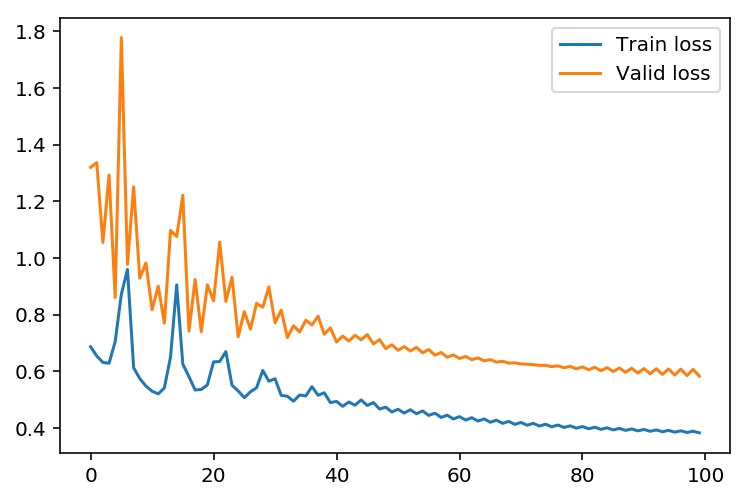

In [26]:
plt.plot(losses_tx2['train'], label='Train loss')
plt.plot(losses_tx2['valid'], label='Valid loss')
plt.legend()
_ = plt.ylim()

## Test predictions

Here, we test our NN on the test data to view how well the NN is modeling/predicting the test dataset. 
If something is wrong, the NN is NOT implemented correctly.

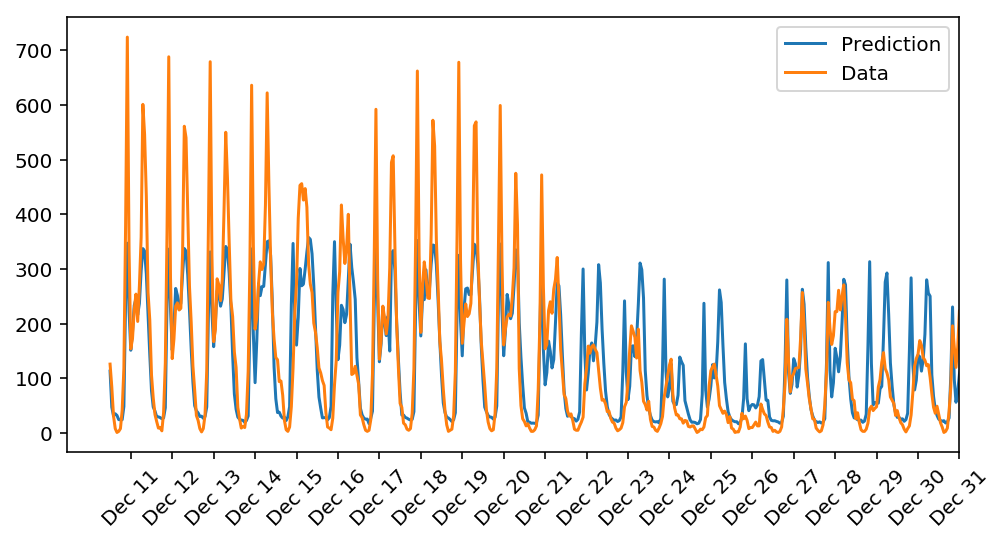

In [27]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions_tx1 = nn.run(test_features_txn).T*std + mean
ax.plot(predictions_tx1[0], label='Prediction')
ax.plot((test_targets_txm['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions_tx1))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

# Discussion: Thinking about our results for conclusion and wrap-up.
 
Answer these questions concluding our results or for drawing conclusion out of the results:
How well does the NN predict/model the data? 
Where does it fail? 
Why does it fail in the place it fails?